#**Stats and Market Value Correlation**

In [2]:
#@title **Stats**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

def heatmap_plt(corr, type):
  
  plt.figure(figsize = (15, 10))
  mapping = sns.heatmap(
  corr, 
  vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
  )
  plt.title(type+' Heatmap')
  plt.show()


def boxplot_plt(attr):

  sns.boxplot(y = attr\
              , showfliers=False\
              )


def scatter_plt(x, y, xl, yl, sson, type):

  plt.scatter(x, y)
  plt.title(sson + ' season'+type)
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.show()


def mv_corr(pos, season, plt_type, val1, val2, clean_outliers):

  players_df = pd.read_pickle('/content/drive/My Drive/Capstone/Data/Clean/Players_Clean.pkl')
  stats_df = pd.read_pickle('/content/drive/My Drive/Capstone/Data/Clean/stats_Clean.pkl')
  markval_df = pd.read_pickle('/content/drive/My Drive/Capstone/Data/Clean/markval_Clean.pkl')

  corr_df = pd.DataFrame(columns=None)

  players_df.reset_index(drop=True, inplace=True)

  terminate_players = players_df[(players_df['main_field_position'] != pos) | (players_df['age'].isna())].index
  players_df.drop(terminate_players, inplace=True)
  players_df.reset_index(drop=True, inplace=True)

  corr_df['tm_id'] = players_df['tm_id']
  corr_df['age'] = players_df['age'].astype(int) - (20 - int(season[3:]))

  stats_df.reset_index(drop=True, inplace=True)
  terminate_stats = stats_df[(stats_df['season'] != season)\
                             | (~stats_df['tm_id'].isin(corr_df['tm_id']))].index
  stats_df.drop(terminate_stats, inplace=True)
  stats_df.drop(columns=['club', 'season', 'competition'], inplace=True)
  stats_df.reset_index(drop=True, inplace=True)
  mean_stats = pd.pivot_table(stats_df, index='tm_id', columns='attribute', values='value', aggfunc=np.mean, fill_value=0)
  stats_df = pd.pivot_table(stats_df, index='tm_id', columns='attribute', values='value', aggfunc=np.sum, fill_value=0)
  stats_df['ppg'] = mean_stats['ppg'] / 100

  corr_df.set_index('tm_id', inplace=True)

  if(pos == 'goalkeepers'):
    corr_df[['app', 'cs', 'gc', 'mp', 'og', 'ppg', 'yc', 'syc', 'rc', 'son', 'soff', 's']]\
        = stats_df[['app', 'cs', 'gc', 'mp', 'og', 'ppg', 'yc', 'syc', 'rc', 'son', 'soff', 's']]
  else:
    corr_df[['app', 'a', 'g', 'mpg', 'mp', 'og', 'ppg', 'yc', 'syc', 'rc', 'son', 'soff', 's']]\
        = stats_df[['app', 'a', 'g', 'mpg', 'mp', 'og', 'ppg', 'yc', 'syc', 'rc', 'son', 'soff', 's']]

  if(pos == 'goalkeepers'):
    upper_whisker = 3000000
  elif(pos == 'defenders'):
    upper_whisker = 5000000
  elif(pos == 'midfielders'):
    upper_whisker = 7000000
  elif(pos == 'attackers'):
    upper_whisker = 12000000

  corr_df.reset_index(inplace=True)
  markval_df.reset_index(drop=True, inplace=True)
  if(not clean_outliers):
    terminate_mv_season = markval_df[(markval_df['season'] != season)\
                                    | (~markval_df['tm_id'].isin(corr_df['tm_id']))\
                                    ].index
  else:                                  
    terminate_mv_season = markval_df[(markval_df['season'] != season)\
                                    | (~markval_df['tm_id'].isin(corr_df['tm_id']))\
                                    | (markval_df['mv'] > upper_whisker)\
                                    ].index
  markval_df.drop(terminate_mv_season, inplace=True)
  markval_df.reset_index(drop=True, inplace=True)
  corr_df.set_index('tm_id', inplace=True)

  markval_df.sort_values('tm_id', inplace=True)
  markval_df.drop_duplicates(subset='tm_id', keep='first', inplace=True)
  markval_df.set_index('tm_id', inplace=True)

  corr_df['mv'] = markval_df['mv']

  terminate_corr = corr_df[(corr_df['mv'].isna()) |\
            (corr_df['ppg'].isna())].index
  corr_df.drop(terminate_corr, inplace=True)
  corr_df['mv'] = corr_df['mv'].astype(int)
  corr_df.reset_index(drop=True, inplace=True)

  ratio_df = corr_df.copy()
  if(pos == 'goalkeepers'):
    ratio_df['cs'] = np.where(ratio_df['app'] != 0, ratio_df['cs']/ratio_df['app'], 0)
    ratio_df['gc'] = np.where(ratio_df['app'] != 0, ratio_df['gc']/ratio_df['app'], 0)
  else:
    ratio_df['g'] = np.where(ratio_df['app'] != 0, ratio_df['g']/ratio_df['app'], 0)
    ratio_df['a'] = np.where(ratio_df['app'] != 0, ratio_df['a']/ratio_df['app'], 0)

  ratio_df['yc'] = np.where(ratio_df['app'] != 0, ratio_df['yc']/ratio_df['app'], 0)
  ratio_df['syc'] = np.where(ratio_df['app'] != 0, ratio_df['syc']/ratio_df['app'], 0)
  ratio_df['rc'] = np.where(ratio_df['app'] != 0, ratio_df['rc']/ratio_df['app'], 0)
  ratio_df['og'] = np.where(ratio_df['app'] != 0, ratio_df['og']/ratio_df['app'], 0)
  ratio_df['son'] = np.where(ratio_df['app'] != 0, ratio_df['son']/ratio_df['app'], 0)
  ratio_df['soff'] = np.where(ratio_df['app'] != 0, ratio_df['soff']/ratio_df['app'], 0)
  ratio_df['app'] = np.where(ratio_df['s'] != 0, ratio_df['app']/ratio_df['s'], 0)

  corr = corr_df.corr()
  ratio_corr = ratio_df.corr()

  if(plt_type == 'heatmap'):
    heatmap_plt(corr, 'Correlatio')
    heatmap_plt(ratio_corr, 'Ratio Correlation')
  elif(plt_type == 'scatter'):
    scatter_plt(corr_df[val1], corr_df[val2], val1, val2, season, ' Scatterplot')
    scatter_plt(ratio_df[val1], ratio_df[val2], val1, val2, season, ' Ratio Scatterplot')
  elif(plt_type == 'boxplot'):
    boxplot_plt(corr_df[val1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* Player age (age)
* Appearances | app/s (app)
* Assists | a/app (a)
* Goals | g/app (g)
* Minutes per goal (mpg)
* Clean sheets | cs/app (cs)
* Goals conceded | gc/app (gc)
* Minutes played (mp)
* Own goals | og/app (og)
* Points per game (ppg)
* Yellow cards | yc/app (yc)
* Second yellow cards | syc/app (syc)
* Red cards | rc/app (rc)
* Substitutions on | son/app (son)
* Substitutions off | soff/app (soff)
* Squad inclusions (s)
* Market Value (mv)



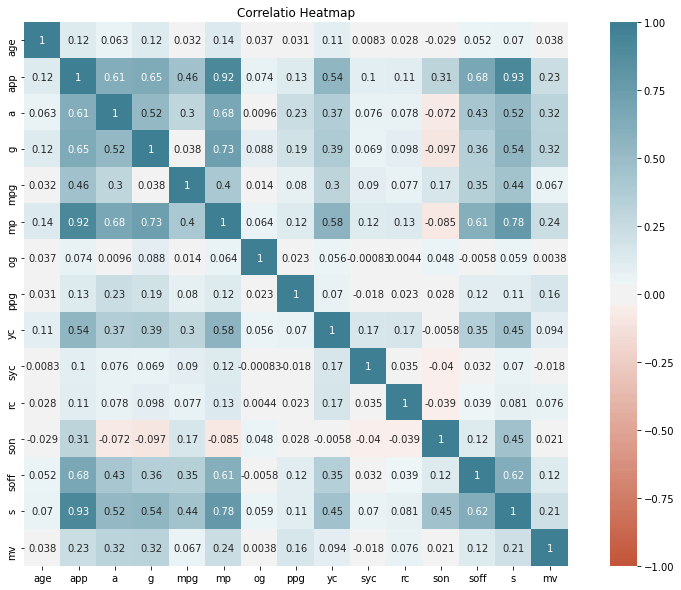

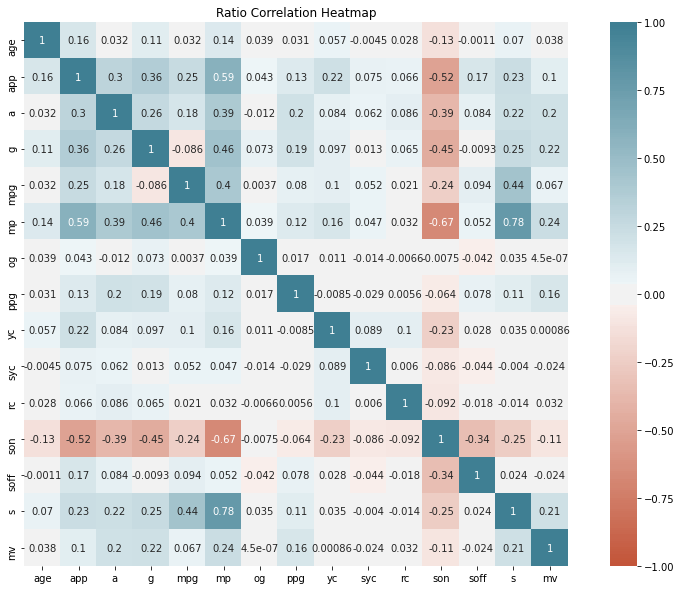

In [3]:
#@title **Heatmap**
position = "attackers" #@param ["goalkeepers", "defenders", "midfielders", "attackers"]
season = 2019 #@param {type:"slider", min:2006, max:2019, step:1}
clean_outliers = False #@param {type:"boolean"}
seas = str(season-1)[2:]+'/'+str(season)[2:]
mv_cor = mv_corr(position, seas, 'heatmap', '', '', clean_outliers)

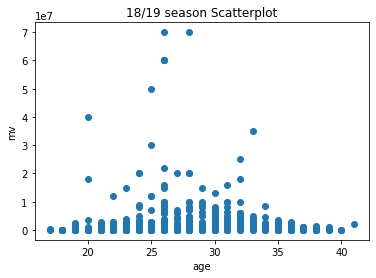

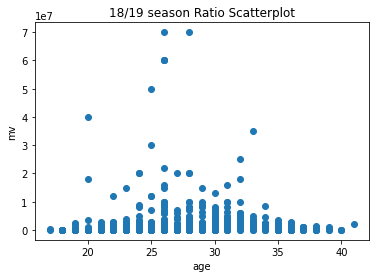

In [7]:
#@title **Scatter Plot**
position = "goalkeepers" #@param ["goalkeepers", "defenders", "midfielders", "attackers"]
season = 2019 #@param {type:"slider", min:2006, max:2019, step:1}
attribute1 = "age" #@param ["age", "app", "a", "g", "mpg", "cs", "gc", "mp", "og", "ppg", "yc", "syc", "rc", "son", "soff", "s", "mv"]
attribute2 = "mv" #@param ["age", "app", "a", "g", "mpg", "cs", "gc", "mp", "og", "ppg", "yc", "syc", "rc", "son", "soff", "s", "mv"]
clean_outliers = False #@param {type:"boolean"}
seas = str(season-1)[2:]+'/'+str(season)[2:]
mv_corr(position, seas, 'scatter', attribute1, attribute2, clean_outliers)

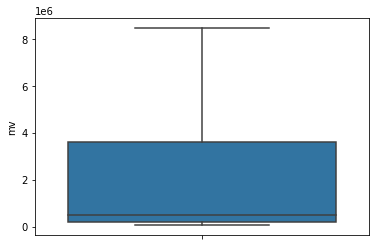

In [5]:
#@title **Box Plot**
position = "attackers" #@param ["goalkeepers", "defenders", "midfielders", "attackers"]
season = 2006 #@param {type:"slider", min:2006, max:2019, step:1}
attribute1 = "mv" #@param ["age", "app", "a", "g", "mpg", "cs", "gc", "mp", "og", "ppg", "yc", "syc", "rc", "son", "soff", "s", "mv"]
seas = str(season-1)[2:]+'/'+str(season)[2:]
mv_corr(position, seas, 'boxplot', attribute1, '', False)